# ✈️ Plane Ticket Price Prediction

<img src="https://drive.google.com/uc?export=download&id=1n1i1ScTdlwaZUx6evCijlwL--MzZbzHo">

Given *data from air tickets in India*, let's try to predict the **price** of a flights based on the available parameters.

# Getting Started

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings(action='ignore')

Let's load and look at the data.

In [2]:
data = pd.read_excel('../input/plane-ticket-price/Data_Train.xlsx')
data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


First, it is good to get an idea of the **features** that will not be useful to us, of those that we can easily exploit.

For example in the context of flights, it is reasonable to think that *time data* like travel time or departure time are important. It is the same for the *places* and *number of stops*.

After a first glance, the available data is rather interesting. Let's continue with **preprocessing**.

# Preprocessing

I like to build a preprocessing function taking the raw data as input and returning whatever is needed for training and testing.

In [3]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop Route
    df = df.drop(['Route'], axis=1)
    
    # Map airlines by their importance
    airlines = list(data['Airline'].value_counts().index)
    airlines_map = {k: v for v, k in enumerate(airlines)}
    df['Airline'] = df['Airline'].map(airlines_map)
    
    # Extract Days and Months from Date of journey
    df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
    df['Day of Journey'] = df['Date_of_Journey'].apply(lambda x: x.day)
    df['Month of Journey'] = df['Date_of_Journey'].apply(lambda x: x.month)
    df = df.drop('Date_of_Journey', axis=1)
    
    # Convert departure and arrival times to minute of the day
    df['Dep_Time'] = pd.to_datetime(df['Dep_Time'])
    df['Dep_Time'] = df['Dep_Time'].apply(lambda x: x.hour * 60 + x.minute)
    df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time'])
    df['Arrival_Time'] = df['Arrival_Time'].apply(lambda x: x.hour * 60 + x.minute)   
    
    # Duration converting to minutes
    df['H'] = df['Duration'].str.extract(r'(\d*(?=h))')
    df['M'] = df['Duration'].str.extract(r'(\d*(?=m))')
    df[['H', 'M']] = df[['H', 'M']].fillna(0)
    df[['H', 'M']] = df[['H', 'M']].astype(int)
    df['Duration'] = df['H'] * 60 + df['M']
    df = df.drop(['H', 'M'], axis=1)
    
    # Convert nb of stops into integer
    df['Total_Stops'] = df['Total_Stops'].replace({'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4})
    
    # Features from Additional info
    df['Included Meal'] = df['Additional_Info'].apply(lambda x: 0 if x == 'In-flight meal not included' else 1)
    df['Included Baggage'] = df['Additional_Info'].apply(lambda x: 0 if x == 'No check-in baggage included' else 1)
    df = df.drop('Additional_Info', axis=1)
    
    # Source and Destination encoding (One-hot)
    df = pd.concat([df, pd.get_dummies(df['Source'], prefix='S')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['Destination'], prefix='D')], axis=1)
    df = df.drop(['Source', 'Destination'], axis=1)
    
    # Fill in the single remaining missing value (Total Stops) with 0
    df = df.fillna(0)
    
    # Split X and y
    X = df.drop(['Price'], axis=1)
    y = df['Price']
    
    # Apply log function to target price
    y = np.log(y)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0)
    
    # Scale X
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)
X_train

,Airline,Dep_Time,Arrival_Time,Duration,Total_Stops,Day of Journey,Month of Journey,Included Meal,Included Baggage,S_Banglore,S_Chennai,S_Delhi,S_Kolkata,S_Mumbai,D_Banglore,D_Cochin,D_Delhi,D_Hyderabad,D_Kolkata,D_New Delhi
508,1.769468,1.300153,0.747300,1.403530,0.270062,0.943622,-0.187969,0.476807,0.177139,-0.510000,-0.193359,-0.858688,1.653826,-0.264554,1.653826,-0.858688,-0.369782,-0.264554,-0.193359,-0.306982
3071,2.848407,-1.091121,0.099238,-0.334039,0.270062,1.285349,-0.857435,0.476807,0.177139,-0.510000,-0.193359,-0.858688,1.653826,-0.264554,1.653826,-0.858688,-0.369782,-0.264554,-0.193359,-0.306982
2036,-0.927880,1.734930,-0.487685,0.110226,0.270062,-1.106741,0.146764,0.476807,0.177139,1.960783,-0.193359,-0.858688,-0.604659,-0.264554,-0.604659,-0.858688,-0.369782,-0.264554,-0.193359,3.257516
49,-0.927880,1.778408,0.771755,1.097481,1.758105,1.627076,0.146764,-2.097286,0.177139,-0.510000,-0.193359,1.164567,-0.604659,-0.264554,-0.604659,1.164567,-0.369782,-0.264554,-0.193359,-0.306982
9686,-0.388411,1.633482,-1.893855,-0.956010,-1.217980,1.627076,-0.187969,0.476807,0.177139,-0.510000,-0.193359,-0.858688,1.653826,-0.264554,1.653826,-0.858688,-0.369782,-0.264554,-0.193359,-0.306982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9225,-0.927880,-1.105614,-1.331387,1.364040,0.270062,-0.765014,2.155162,-2.097286,0.177139,-0.510000,-0.193359,-0.858688,1.653826,-0.264554,1.653826,-0.858688,-0.369782,-0.264554,-0.193359,-0.306982
4859,0.151059,1.590004,0.808437,1.255441,1.758105,-0.765014,1.150963,0.476807,0.177139,-0.510000,-0.193359,1.164567,-0.604659,-0.264554,-0.604659,1.164567,-0.369782,-0.264554,-0.193359,-0.306982
3264,-0.927880,-0.844748,-1.368070,1.156716,0.270062,-1.106741,-0.857435,0.476807,0.177139,-0.510000,-0.193359,1.164567,-0.604659,-0.264554,-0.604659,1.164567,-0.369782,-0.264554,-0.193359,-0.306982
9845,-0.927880,-0.236060,-0.169768,1.709579,0.270062,0.601894,-0.187969,-2.097286,0.177139,-0.510000,-0.193359,1.164567,-0.604659,-0.264554,-0.604659,1.164567,-0.369782,-0.264554,-0.193359,-0.306982


# Models

Now preprocessing is done, we can try multiple different models with our data in order to select the best at the end and optimize it.

In [5]:
models = {
    "Random Forest" : RandomForestRegressor(),
    "      XGBoost" : XGBRegressor(),
    "     LightGBM" : LGBMRegressor(),
    "     CatBoost" : CatBoostRegressor(verbose=0)
}

print("-------- Training --------")
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained!")
print("---------- Done ----------")

-------- Training --------
Random Forest trained!
      XGBoost trained!
     LightGBM trained!
     CatBoost trained!
---------- Done ----------


# Results

Let's visualize the results with different metrics.

Something important before displaying the results is to apply the exponential function to the target since we applied the natural logarithm function during preprocessing.

In [6]:
y_test = np.exp(y_test)

In [7]:
for name, model in models.items():
    y_pred = np.exp(model.predict(X_test))

    print(name + ": R2 Score = {:.4f}".format(r2_score(y_test, y_pred)))
    print("                   RMSE = {:.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
    print("                    MAE = {:.0f}".format(mean_absolute_error(y_test, y_pred)))
    print("                   MAPE = {:.2f} %\n".format(mean_absolute_percentage_error(y_test, y_pred) * 100))

Random Forest: R2 Score = 0.8858
                   RMSE = 1555
                    MAE = 660
                   MAPE = 7.34 %

      XGBoost: R2 Score = 0.8661
                   RMSE = 1684
                    MAE = 775
                   MAPE = 8.33 %

     LightGBM: R2 Score = 0.8563
                   RMSE = 1744
                    MAE = 909
                   MAPE = 9.89 %

     CatBoost: R2 Score = 0.8677
                   RMSE = 1673
                    MAE = 870
                   MAPE = 9.40 %



The Random Forest model gives the best resuts.

Let's look at the predicted values compared to the actual values of the ticket prices.

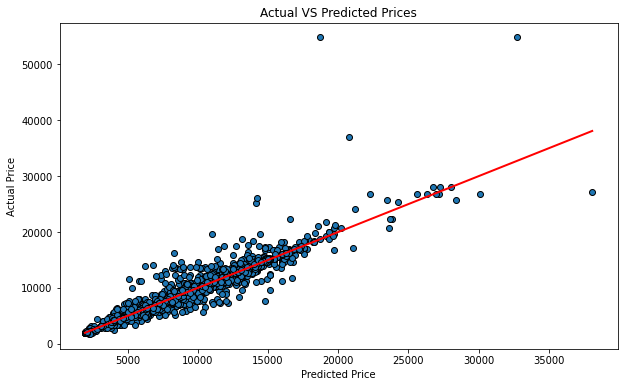

In [8]:
# Random Forest predictions
y_pred = np.exp(models['Random Forest'].predict(X_test))

# Display
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test, edgecolor='k')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], c='r', lw=2)
plt.title("Actual VS Predicted Prices")
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.show()

As we can see, the model seems to give correct predictions in general.

It should be noted that we have not done any work on the **outliers**. Of course, a little more thorough cleaning of the data would give us even better results.

Thank you very much for reading my work until the end. If you have any suggestion, please let me know.

**Have a nice day! 🙂**